In [11]:
from crypto_package import get_candles
from crypto_package.backtesting import plot_profit, plot_candles, BacktestingBot, plot_indicators
import talib.abstract as ta

In [393]:
import datetime
from pandas import to_datetime
import plotly.graph_objects as go
from random import randint
def plot_patterns_on_candles(indicators_df, indicators, trades=None, pair=None, show_signal=False, lines=[], width: int = 1000,
                    height: int = 650):  # indicators_df contains columns with indicators and column "date" with datetime
    if "time" in indicators_df.columns:
        indicators_df = indicators_df.rename(columns={"time": "date"})
    if type(indicators_df["date"][0]) is not datetime:
        indicators_df["date"] = to_datetime(indicators_df["date"], unit='s')

    fig = go.Figure()

    fig.add_trace(go.Candlestick(
        x=indicators_df['date'],
        open=indicators_df['open'],
        high=indicators_df['high'],
        low=indicators_df['low'],
        close=indicators_df['close']))

    for ind in indicators:
        xup =[]
        xdown = []
        yup = []
        ydown = []
        
        for idx, row in indicators_df.iterrows():
            if row[ind]==100:
                xup.append(row['date'])
                yup.append(100+((row['open']+row['close'])/2)+abs(row['open']-row['close']))
            elif row[ind]==-100:
                xdown.append(row['date'])
                ydown.append(-100+((row['open']+row['close'])/2)-abs(row['open']-row['close']))
        
        color = 'green' if len(indicators)<=2 else randint(1,500)
        fig.add_trace(go.Scatter(
            x=xup,
            y=yup,
            mode='markers',
            marker=dict(
                color=color,
                line_width=1,
                size=8,
            ),
            marker_symbol='triangle-up',
            name=ind+" bullish",
        ))
        color = 'red' if len(indicators)<=2 else randint(1,500)
        fig.add_trace(go.Scatter(
            x=xdown,
            y=ydown,
            mode='markers',
            marker=dict(
                color=color,
                line_width=1,
                size=8,
            ),
            marker_symbol='triangle-down',
            name=ind+" bearish",
        ))
    
    for line in lines:
        fig.add_trace(go.Scatter(
            x=indicators_df["date"],
            y=indicators_df[line],
            mode='lines',
            name=line,
        ))
    
    if trades is not None:
        res = trades.trades

        if pair is not None:
            res = [t for t in trades.trades if t.pair == pair]

        buy_trades_price = [tr.price for tr in res if tr.is_buy]
        buy_trades_time = [tr.timestamp for tr in res if tr.is_buy]

        sell_trades_price = [tr.price for tr in res if not tr.is_buy]
        sell_trades_time = [tr.timestamp for tr in res if not tr.is_buy]

        fig.add_trace(go.Scatter(
            x=buy_trades_time,
            y=buy_trades_price,
            mode='markers',
            name='buy trades',
            marker_symbol='diamond',
            marker=dict(
                color='blue',
                line_width=2,
                size=7,

            )
        ))

        fig.add_trace(go.Scatter(
            x=sell_trades_time,
            y=sell_trades_price,
            mode='markers',
            name='sell trades',
            marker_symbol='square',
            marker=dict(
                color='yellow',
                line_width=2,
                size=7
            )
        ))
        
        if show_signal:
            buy_sig = [a[0] for a in trades.buy_signals]
            buy_sig_time = [a[1] for a in trades.buy_signals]
            
            sell_sig = [a[0] for a in trades.sell_signals]
            sell_sig_time = [a[1] for a in trades.sell_signals]
            fig.add_trace(go.Scatter(
                x=buy_sig_time,
                y=buy_sig,
                mode='markers',
                name='buy signal',
                marker_symbol='diamond',
                marker=dict(
                    color='lightblue',
                    line_width=2,
                    size=7,

                )
            ))

            fig.add_trace(go.Scatter(
                x=sell_sig_time,
                y=sell_sig,
                mode='markers',
                name='sell signal',
                marker_symbol='square',
                marker=dict(
                    color='lightyellow',
                    line_width=2,
                    size=7
                )
            ))
    
    fig.update_layout(
        title="Indicators on candles",
        xaxis_title="time",
        yaxis_title="value",
        width=width,
        height=height
    )
    fig.show()

    
    
    
    
from plotly.subplots import make_subplots

def plot_indicators(indicators_df, indicators, trades=None, pair=None, show_signal=False, plot_candles=False, one_plot=None, width: int = 1000, height: int = 650, fig_type:str='lines'):  # indicators_df contains columns with indicators and column "date" with datetime
    if "time" in indicators_df.columns:
        indicators_df = indicators_df.rename(columns={"time": "date"})
    if type(indicators_df["date"][0]) is not datetime:
        indicators_df["date"] = to_datetime(indicators_df["date"], unit='s')
   
    rows = 0
    indicators_titles = []
    
    if plot_candles or trades is not None:
        rows += 1
        indicators_titles = ['candles']
    
    if one_plot is not None:
        for idx,i in enumerate(one_plot):
            if i==False:
                rows += 1
                indicators_titles.append(indicators[idx])
            else:
                title = indicators_titles.pop() if len(indicators_titles)>0 else ""
                title = title + " + " + str(indicators[idx])
                indicators_titles.append(title)
    else:
        rows += len(indicators)
        indicators_titles += [i for i in indicators]
        
    
   
    
    print(indicators_titles)
    fig = make_subplots(rows=rows, cols=1, 
                        subplot_titles=indicators_titles,
                        shared_xaxes=True,
                        vertical_spacing=0.05)
    
    ridx = 0
    if plot_candles or trades is not None:
        ridx = 1
        fig.add_trace(go.Candlestick(
            x=indicators_df['date'],
            open=indicators_df['open'],
            high=indicators_df['high'],
            low=indicators_df['low'],
            close=indicators_df['close']), row=ridx, col=1
                      )

        
        if trades is not None:
            res = trades.trades

            if pair is not None:
                res = [t for t in trades.trades if t.pair == pair]

            buy_trades_price = [tr.price for tr in res if tr.is_buy]
            buy_trades_time = [tr.timestamp for tr in res if tr.is_buy]

            sell_trades_price = [tr.price for tr in res if not tr.is_buy]
            sell_trades_time = [tr.timestamp for tr in res if not tr.is_buy]

            fig.add_trace(go.Scatter(
                x=buy_trades_time,
                y=buy_trades_price,
                mode='markers',
                name='buy trades',
                marker_symbol='diamond',
                marker=dict(
                    color='blue',
                    line_width=2,
                    size=7,

                )
            ),row=ridx, col=1)

            fig.add_trace(go.Scatter(
                x=sell_trades_time,
                y=sell_trades_price,
                mode='markers',
                name='sell trades',
                marker_symbol='square',
                marker=dict(
                    color='yellow',
                    line_width=2,
                    size=7
                )
            ),row=ridx, col=1)

            if show_signal:
                buy_sig = [a[0] for a in trades.buy_signals]
                buy_sig_time = [a[1] for a in trades.buy_signals]

                sell_sig = [a[0] for a in trades.sell_signals]
                sell_sig_time = [a[1] for a in trades.sell_signals]
                fig.add_trace(go.Scatter(
                    x=buy_sig_time,
                    y=buy_sig,
                    mode='markers',
                    name='buy signal',
                    marker_symbol='diamond',
                    marker=dict(
                        color='lightblue',
                        line_width=2,
                        size=7,

                    )
                ),row=ridx, col=1)

                fig.add_trace(go.Scatter(
                    x=sell_sig_time,
                    y=sell_sig,
                    mode='markers',
                    name='sell signal',
                    marker_symbol='square',
                    marker=dict(
                        color='lightyellow',
                        line_width=2,
                        size=7
                    )
                ),row=ridx, col=1)
        
        
    for idx,ind in enumerate(indicators):
        if one_plot is None or one_plot[idx]==False:
            ridx += 1
            
        fig.add_trace(go.Scatter(
            x=indicators_df['date'],
            y=indicators_df[ind],
            name = ind,
            line_color='rgb'+str((randint(0,255),randint(0,255),randint(0,255)))
            ),
            row = ridx, 
            col = 1
        )
        
    fig.update_layout(
        title_text='indicators',
        # xaxis_title="time",
        # yaxis_title="value",
        width=width,
        height=height,
        xaxis_rangeslider_visible=False,
        
    )
    fig.show()

1. podstawa
   - rsi jak przekroczyy 30/70
2. poprawki
    - rsi jak wychodzi z zakresów (przekracza w drugą stronę 30/70)



In [325]:
candles, _ = get_candles('binance', 'BTC/USDT', '1h', time_start=datetime.datetime(2021,11,1))

['candles', 'rsi']


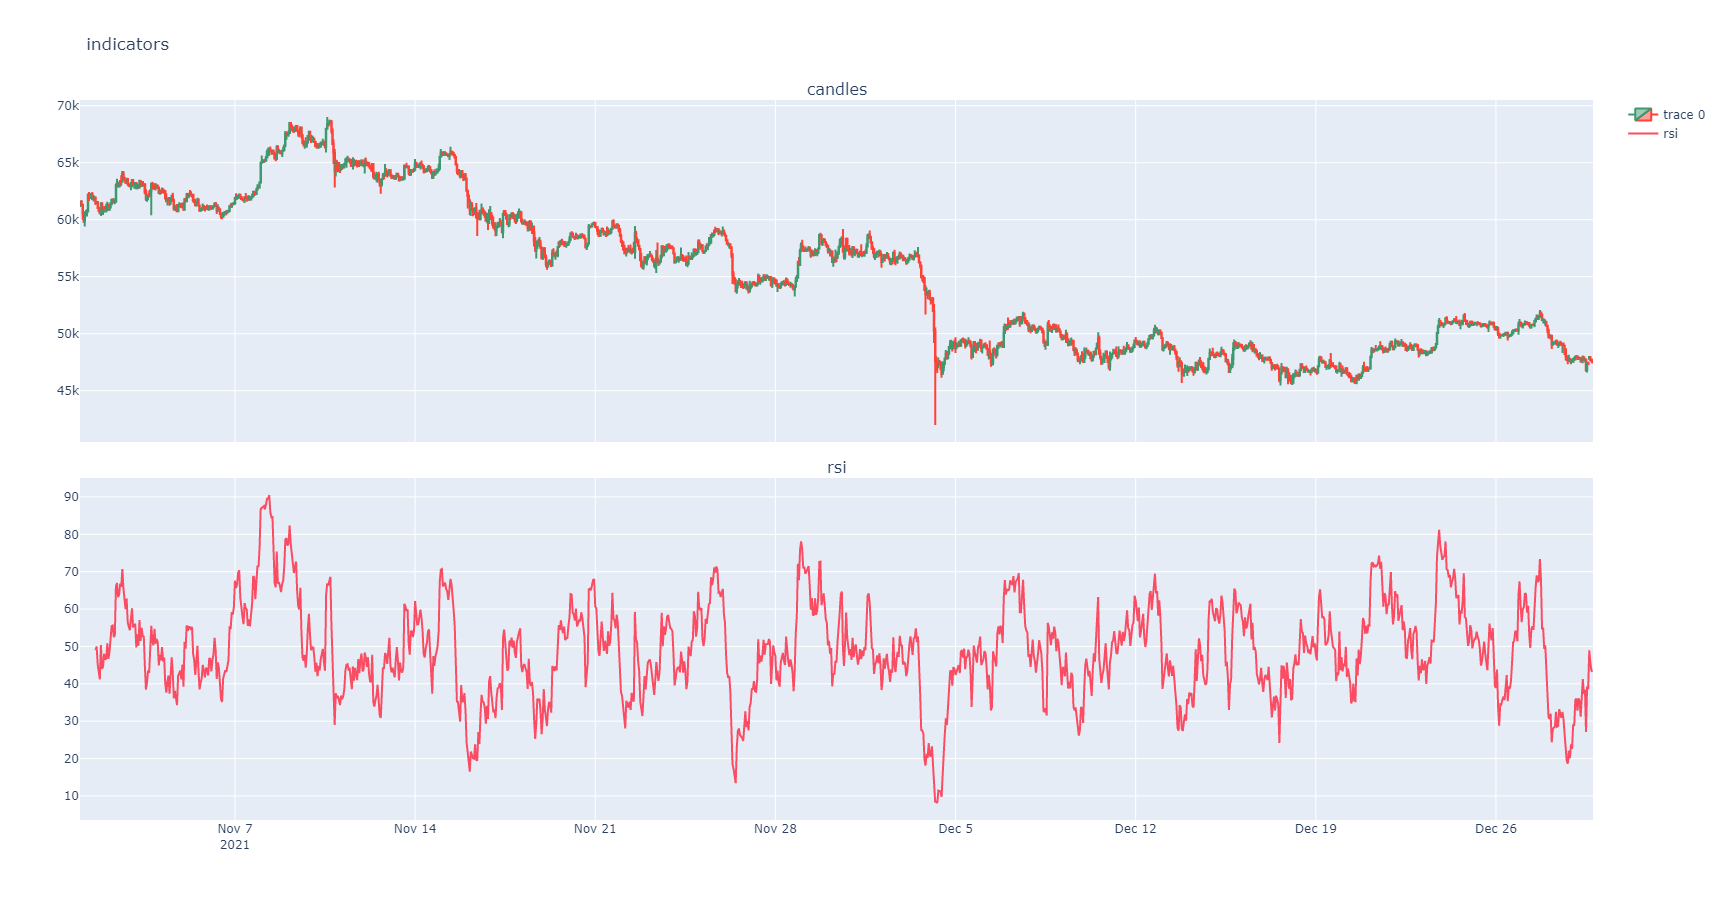

In [326]:
candles['rsi'] = ta.RSI(candles, timeperiod=14)
plot_indicators(candles, ['rsi'], plot_candles=True, width=1800, height=900)

### RSI

* wyłapanie lokalnych górek i dołków
* szybkość zmiany ceny aktywa
* średni wzrost / średni spadek
* rsi >70
    - były duże wzrosty
    - rynek nasycony -> będzie spadać -> lokalny szczyt
* rsi <30 
    - w ciągu timeperiod było zdecydowanie więcej spadków
    - rynek wyprzedany -> będzie kupowane -> lokalny dołek
* mniejszy time-period - wskaźnik bardziej czuły (wtedy zaleca się 80/20)  


kupowanie:
* przekracza 30 w górę (jak pan na yt mówił) - dlaczego?
* lepiej - rsi[-2] < rsi[-1] i oba są < 30 - odbicie od dołka  
sprzedawanie:  
* z jakiegoś powodu tak jak przy kupowaniu lepiej jak przekroczy wartość z powrotem (70 w dół)  


zdecydowanie można wyłapać więcej dołków i górek - zmianić time period i zakrest 70/30

['candles', 'rsi']


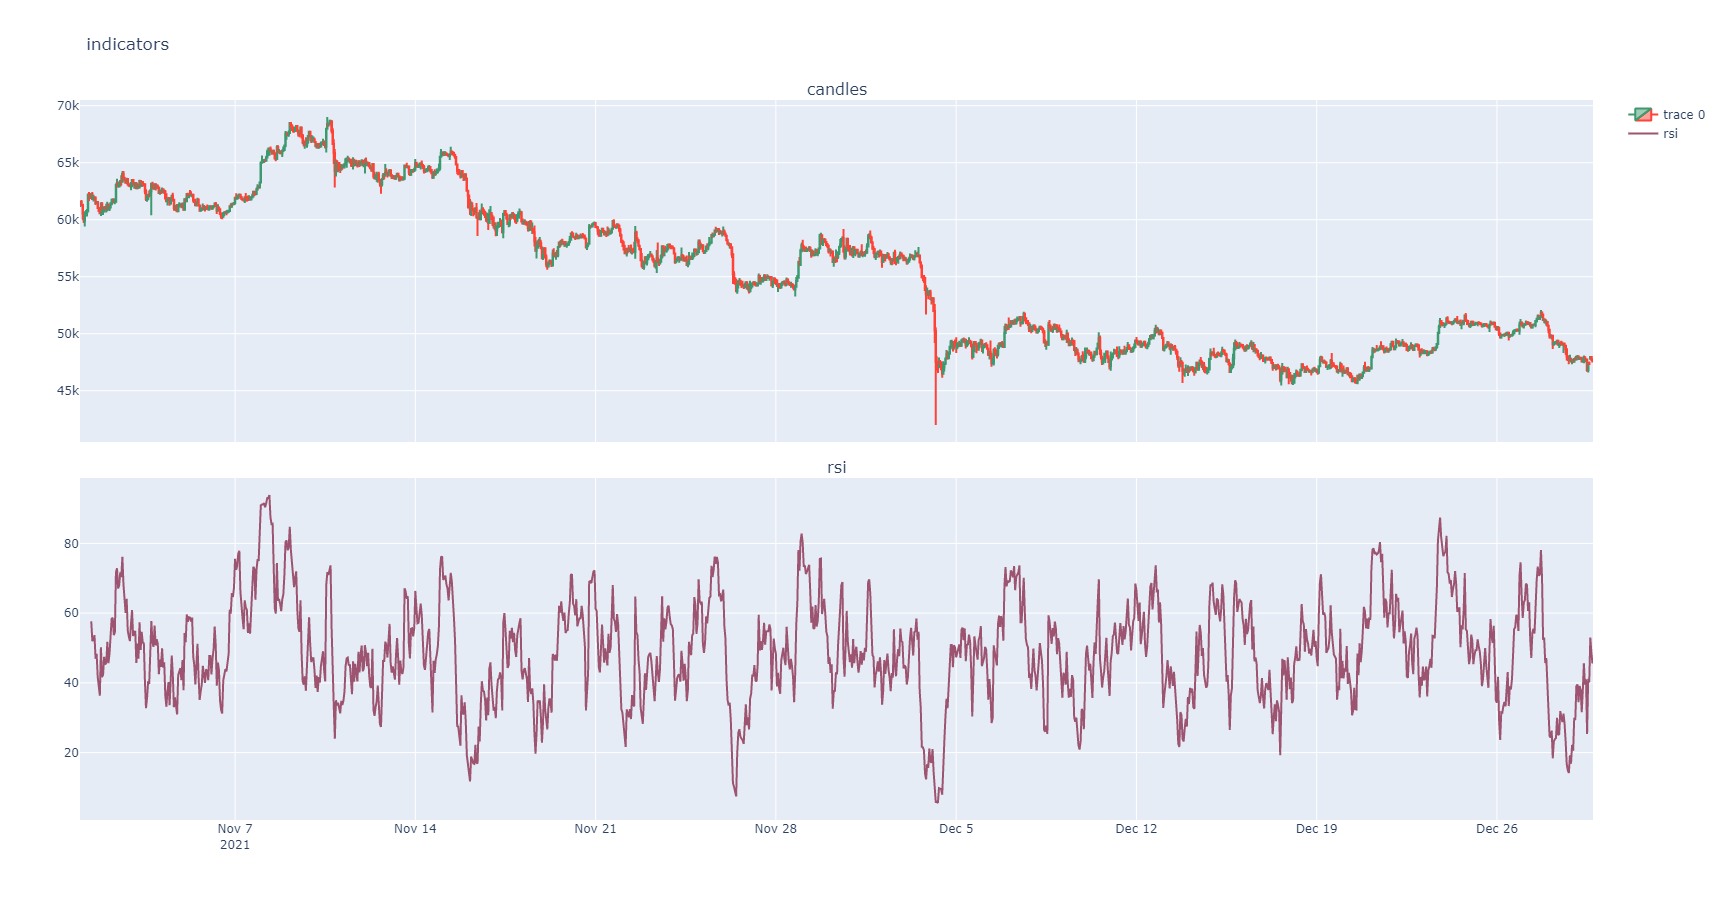

In [309]:
candles['rsi'] = ta.RSI(candles, timeperiod=10)
plot_indicators(candles, ['rsi'], plot_candles=True, width=1800, height=900)

- timeperriod może zostać 10 - wyłapuje więcej górek i dołków
- ograniczenia  - 30/68,8
- sprzedaż przy powrocie

opcje: 
* jaki time_period?
* transakcje na początku przekorczonej granicy? na końcu?


In [361]:
%%writefile simple_strategy/config.yml
# example of bot_entity configuration

 # units of cryptocurrency used by bot_entity to make one buy trade
transaction_amount: 20

# if transaction value will fall by the stop_loss value (percentages), relative to its purchase price, bot_entity will sell it
stop_loss: 20 

# exchange on which bot_entity trades: binance
exchange: binance 

# pairs used to trade (the same strategy will be run on each one): e.g. -BTC/USDT
currency_pairs:
  - BTC/USDT
  
# candle interval. See constraints.yml for available candles
timeframe: 1h 

# from which time do you want to start calculating indicators (select this or last_n_candles): datetime - yyy-mm-dd hh:mm:ss eg. 
#start_time: '2019-06-01 12:22:00'

# to which time download candles to calculate indicators: datetime - yyy-mm-dd hh:mm:ss
#end_time: '2019-06-10 12:22:00'

# based on how many candles do you want to calculate indicators (select this or start_time)
last_n_candles: 200 

# if True when sell signal occurs sell all owned amount of cryptocurrency; if False sell amount on sungle buy transaction
sell_all: False

# in minutes - how long to wait before transaction cancellation (needs to be bigger than zero)
timeout: 30

# maximum number of open trades for bot (for trades of all pairs)
max_open_trades: 5


Overwriting simple_strategy/config.yml


In [362]:
def calc_indicators_simple_1(candles):
    candles['rsi'] = ta.RSI(candles, timeperiod=10)
    return candles

def check_buy_signals_simple_1(indicators):
    buy = False
    if(indicators.iloc[-1]['rsi'] >= 28 and indicators.iloc[-2]['rsi'] < 28):
        buy = True
    
    return buy
    

def check_sell_signals_simple_1(indicators):
    sell = False
    if(indicators.iloc[-1]['rsi'] <= 68.5 and  indicators.iloc[-2]['rsi'] > 68.5):
        sell = True
    
    return sell

/tmp/ipykernel_65/1127243388.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



['candles', 'rsi']


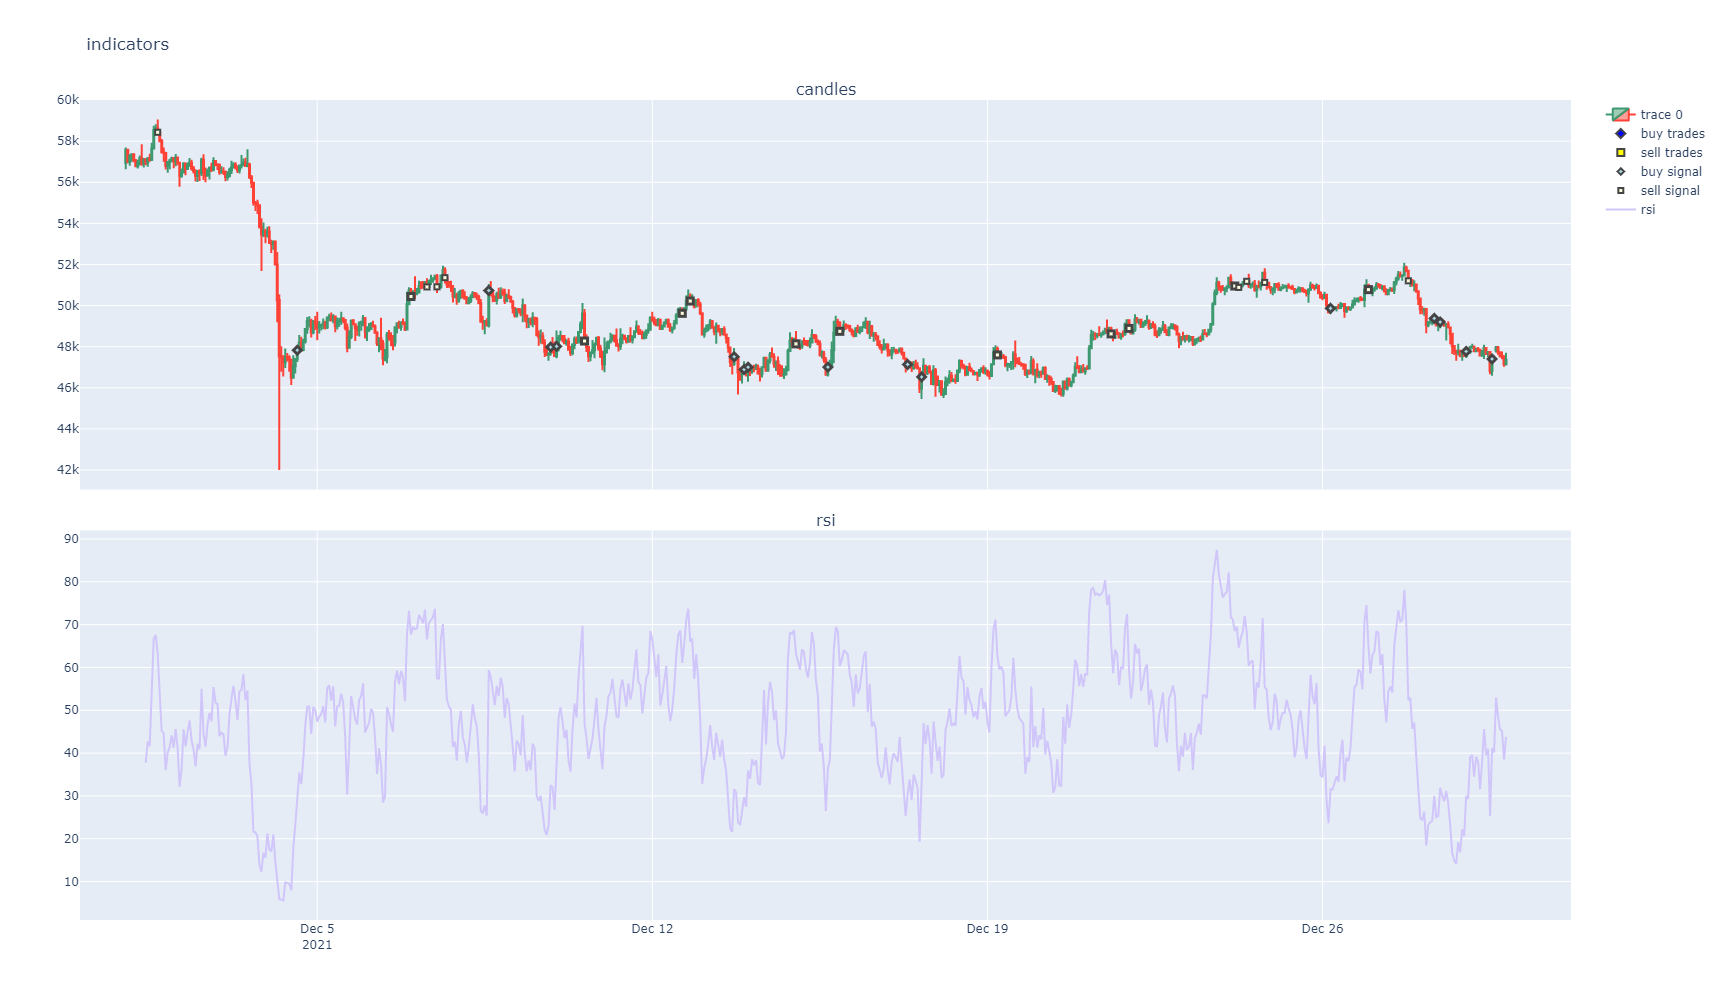

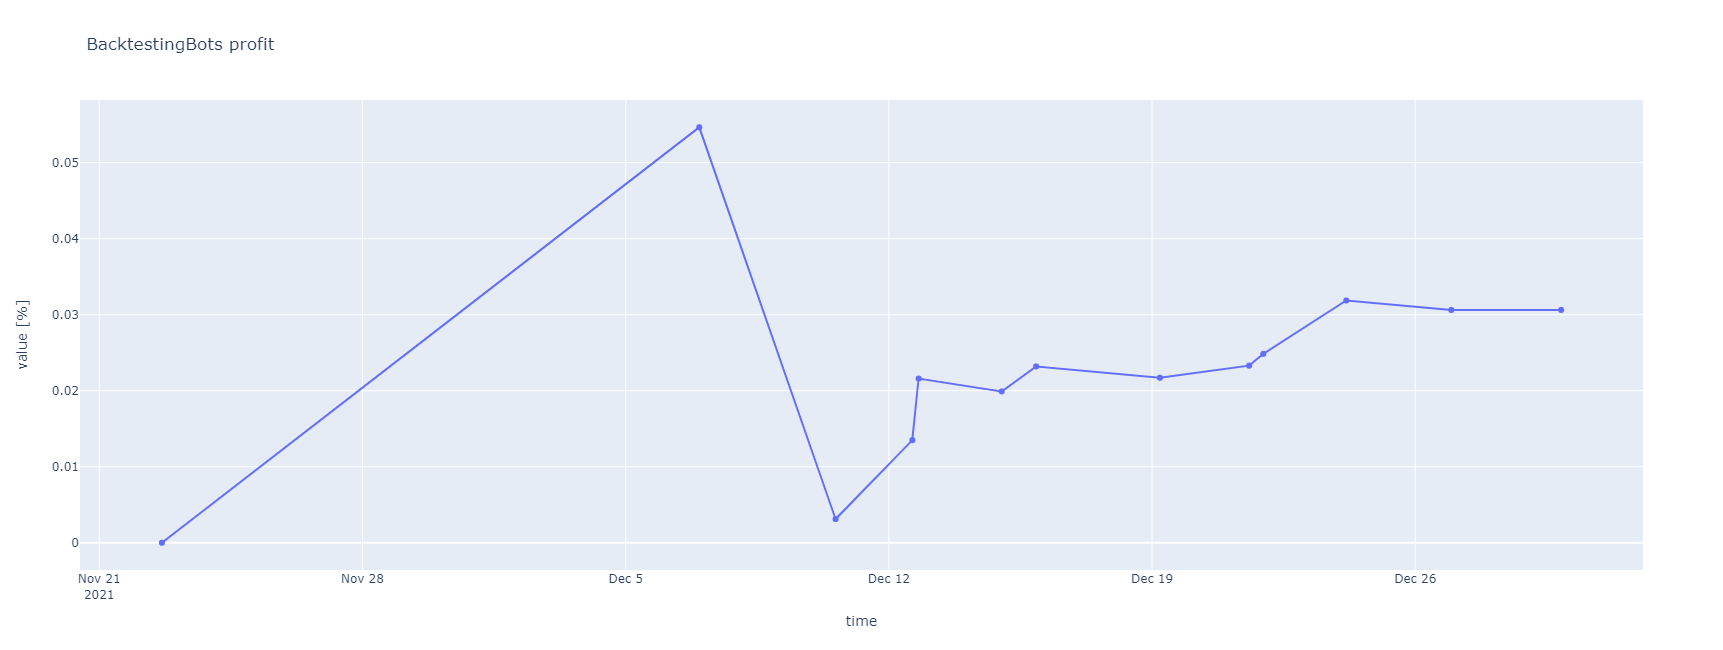

In [371]:
bot_rsi = BacktestingBot('simple_strategy/config.yml')
results_rsi = bot_rsi.test_strategy(calc_indicators_simple_1, check_buy_signals_simple_1, check_sell_signals_simple_1, time_start=datetime.datetime(2021,12,1))
# plot_candles(candles, results_rsi)
plot_indicators(candles, ['rsi'], trades=results_rsi, show_signal=True, width=1800, height=1000)
plot_profit(results_rsi)

1h bo chcemu ograniczyć szumy ale wykorzystywać też lokalne maksima
  
- trzebaby ograniczyć kupowanie przy silnym trendzie spadającym
- czasem kupuje za wolno - cena już urosla aten kupuje

### średnia krocząca
- wskaźnik opóźniony
- odfiltrowuje hałas rynkowy
- podkreśla kierunek trendu
- SMA - simple ma
    * średnia na podstawie x ostatnich dni
    * 200 dniowa SMA reaguje wolniej na najnowsze ceny niż krósza sma
    * wszystkie dane z danego okresu są tak samo ważne
- EMA - wykłądnicza ma
    * większa waga dla ostatnich danych cenowych / najnowszych danych
    * szybciej jest w stanie przewidzieć zmianę trendu
    * lepszy dla krótkoterminowych strategii
- większy zbiór danych - większe opóźnienie
- Traderzy często używają relacji ceny w stosunku do określonych średnich ruchomych, aby poprawnie zmierzyć i określić obecny trend rynkowy. Na przykład, jeśli cena utrzymuje się powyżej 200-dniowego SMA przez dłuższy okres, wielu inwestorów może uznać, że mamy do czynienia z hossą.
- Na przykład, jeśli 100-dniowa SMA przechodzi poniżej 200-dniowej SMA, można to uznać za sygnał sprzedaży. Co dokładnie oznacza te przecięcie? Wskazuje, że średnia cena z ostatnich 100 dni jest teraz niższa niż z ostatnich 200 dni. Idea sprzedaży tutaj polega na tym, że krótkoterminowe ruchy cen nie są już zgodne z trendem wzrostowym, więc istnieje wysoka szansa odwrócenia trendu.
- Na tradycyjnych rynkach najczęściej analizowanymi w MA okresami są 50, 100 oraz 200 dni. 50-dniowe i 200-dniowe Średnie Kroczące są uważnie obserwowane przez inwestorów giełdowych, a wszelkie przebicia występujące powyżej lub poniżej tych narysowanych przez MA linii są zwykle uważane za ważne sygnały handlowe, szczególnie gdy są one poprzedzone tzw. Crossoverami.

- Crossover
    * Golden - krótkoterminowe MA przecina długoterminowe MA i rysuje sie nad nim -> początek wzrostów
    * Niedźwiedzi - krótkoterminowe MA rysuje sie poniżej linii dlugoterminowego MA -> początek spadków

In [364]:
candles, _ = get_candles('binance', 'BTC/USDT', '1h', time_start=datetime.datetime(2021,12,1))

['candles', 'sma_l + sma_ll + ema_l + ema_ls + sma_s + ema_s', 'rsi']


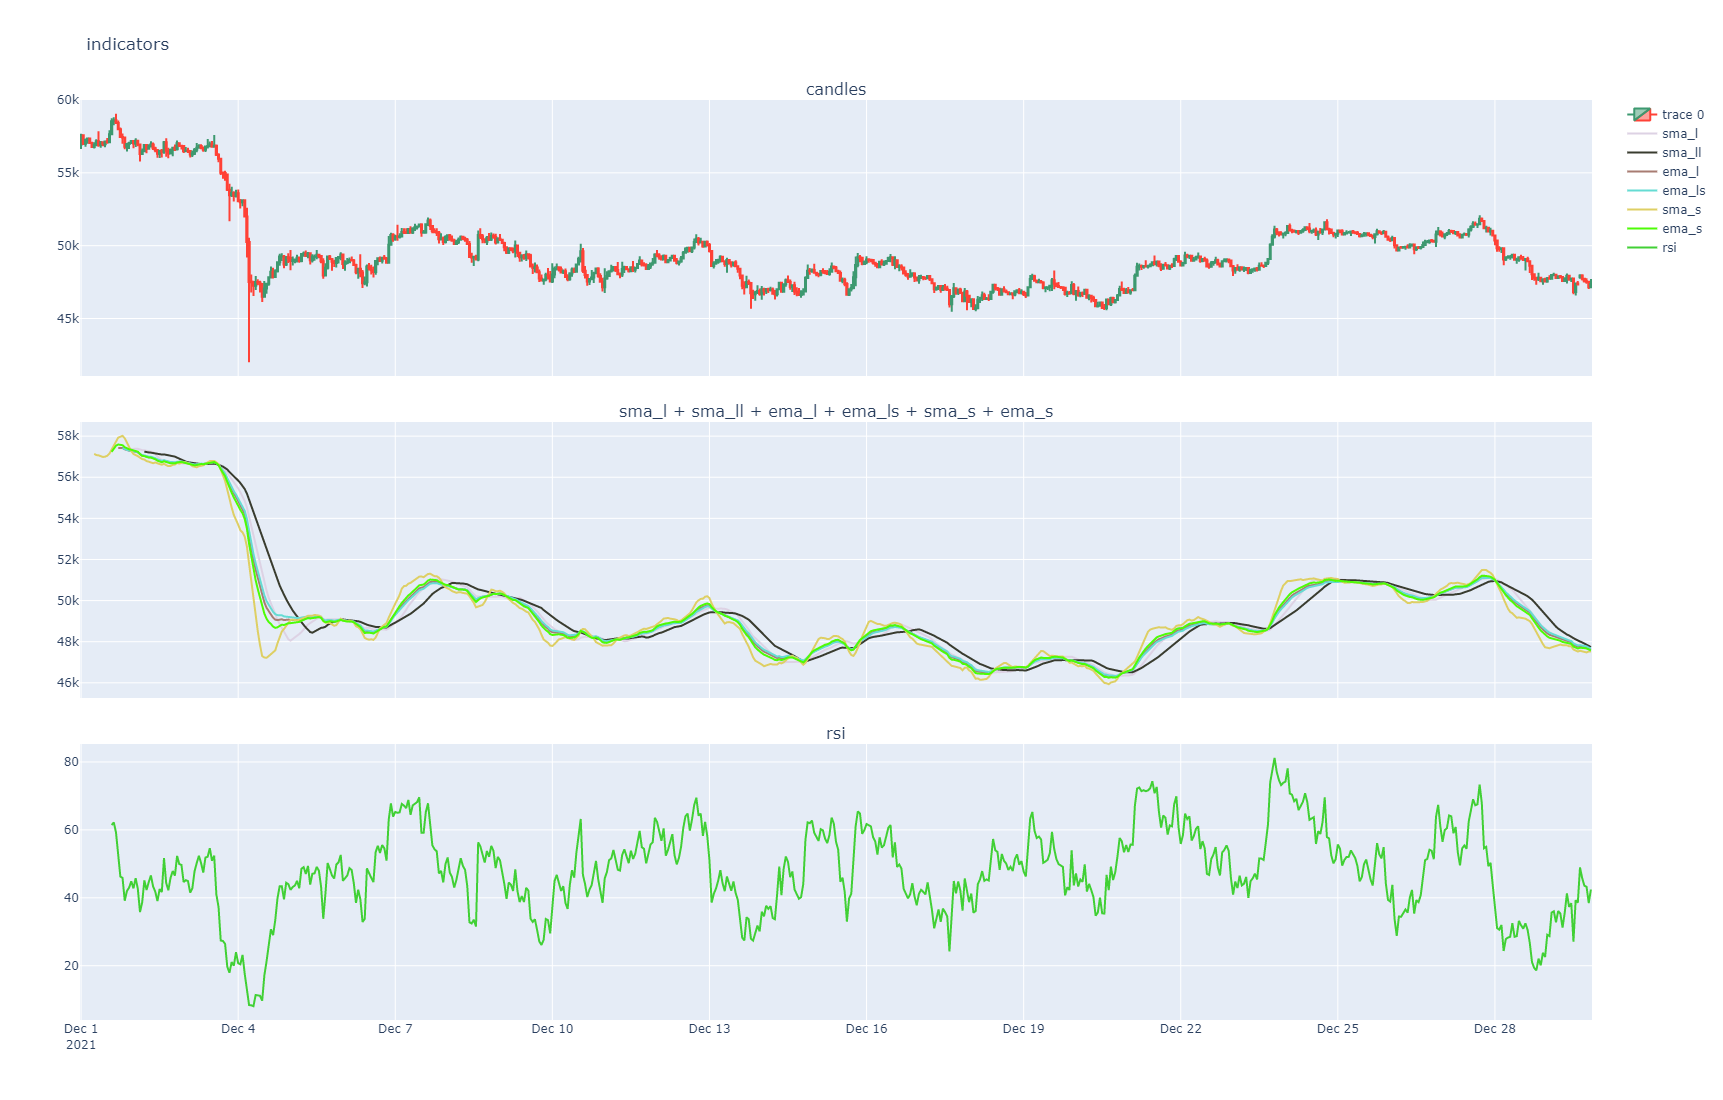

In [365]:
candles['sma_l'] = ta.SMA(candles, timeperiod=20)
candles['sma_ll'] = ta.SMA(candles, timeperiod=30)
candles['ema_l'] = ta.EMA(candles, timeperiod=18)
candles['ema_ls'] = ta.EMA(candles, timeperiod=20)
candles['sma_s'] = ta.SMA(candles, timeperiod=7)
candles['ema_s'] = ta.EMA(candles, timeperiod=15)
candles['rsi'] = ta.RSI(candles, timeperiod=14)
plot_indicators(candles, ['sma_l','sma_ll', 'ema_l', 'ema_ls','sma_s', 'ema_s', 'rsi'], plot_candles=True, one_plot=[False, True, True,True, True, True, False], width=1700, height=1100)

- ema-s przecina sma-l do 3świeczek wstecz to kupuj i do 7świeczek w tył było RSI to kupuj
- ok 6-7 h w plecy
- sma_l do ema_l +- 4/5 h
- zdecydowanie emal przecina się najwcześniej z smal a nie z s i s

In [382]:
def calc_indicators_simple_rsi_ma(candles):
    candles['sma'] = ta.SMA(candles, timeperiod=20)
    candles['ema'] = ta.EMA(candles, timeperiod=20)
    candles['rsi'] = ta.RSI(candles, timeperiod=10)
    return candles

def check_buy_signals_simple_rsi_ma(indicators):
    buy = False
    threshold = 28
    if(indicators.iloc[-1]['sma'] <= indicators.iloc[-1]['ema'] and 
      indicators.iloc[-2]['sma'] >= indicators.iloc[-2]['ema'] and (
          (indicators.iloc[-1]['rsi'] >= threshold and indicators.iloc[-2]['rsi'] < threshold) or
          (indicators.iloc[-2]['rsi'] >= threshold and indicators.iloc[-3]['rsi'] < threshold) or
          (indicators.iloc[-3]['rsi'] >= threshold and indicators.iloc[-4]['rsi'] < threshold) or
          (indicators.iloc[-4]['rsi'] >= threshold and indicators.iloc[-5]['rsi'] < threshold)
      )):
        buy = True
    
#     if(indicators.iloc[-1]['rsi'] >= 28 and indicators.iloc[-2]['rsi'] < 28):
#         buy = True
    
    return buy
    

def check_sell_signals_simple_rsi_ma(indicators):
    sell = False
    threshold = 68.5
    if(indicators.iloc[-1]['sma'] >= indicators.iloc[-1]['ema'] and 
      indicators.iloc[-2]['sma'] <= indicators.iloc[-2]['ema'] and (
          (indicators.iloc[-1]['rsi'] <= threshold and indicators.iloc[-2]['rsi'] > threshold) or
          (indicators.iloc[-2]['rsi'] <= threshold and indicators.iloc[-3]['rsi'] > threshold) or
          (indicators.iloc[-3]['rsi'] <= threshold and indicators.iloc[-4]['rsi'] > threshold) or
          (indicators.iloc[-4]['rsi'] <= threshold and indicators.iloc[-5]['rsi'] > threshold)
      )):
    # if(indicators.iloc[-1]['rsi'] <= 68.5 and  indicators.iloc[-2]['rsi'] > 68.5):
        sell = True
    
    return sell

/tmp/ipykernel_65/1360973860.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65/1360973860.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65/1360973860.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



['candles']


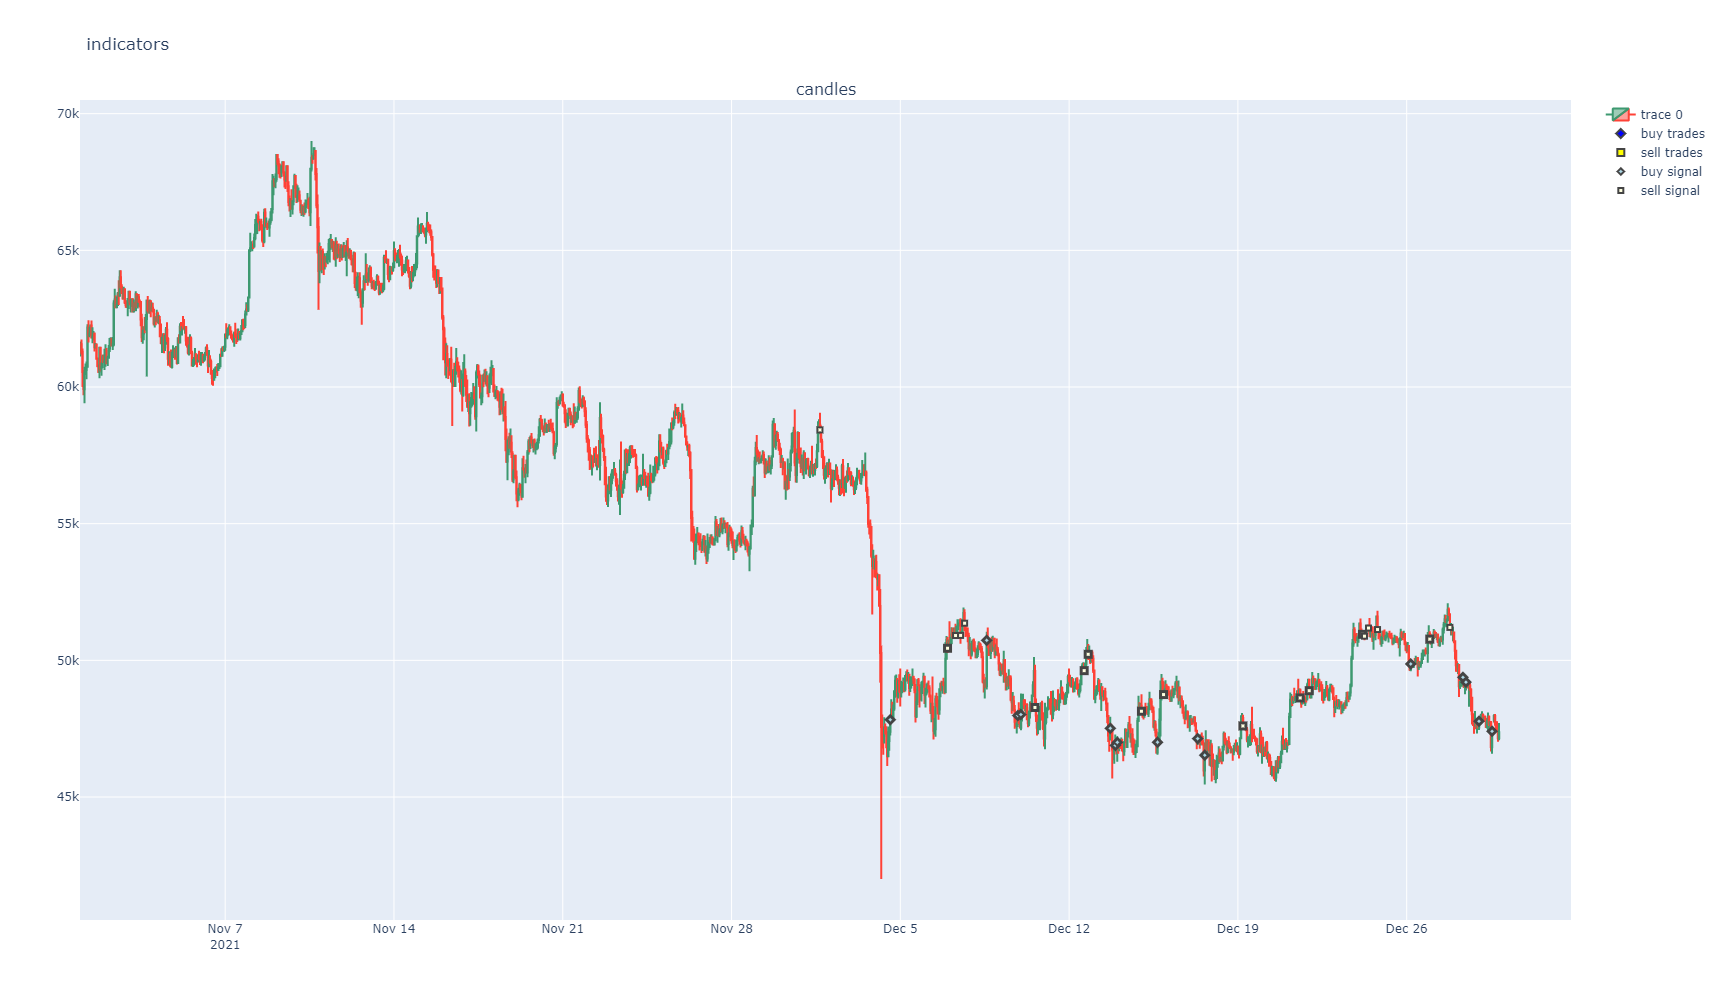

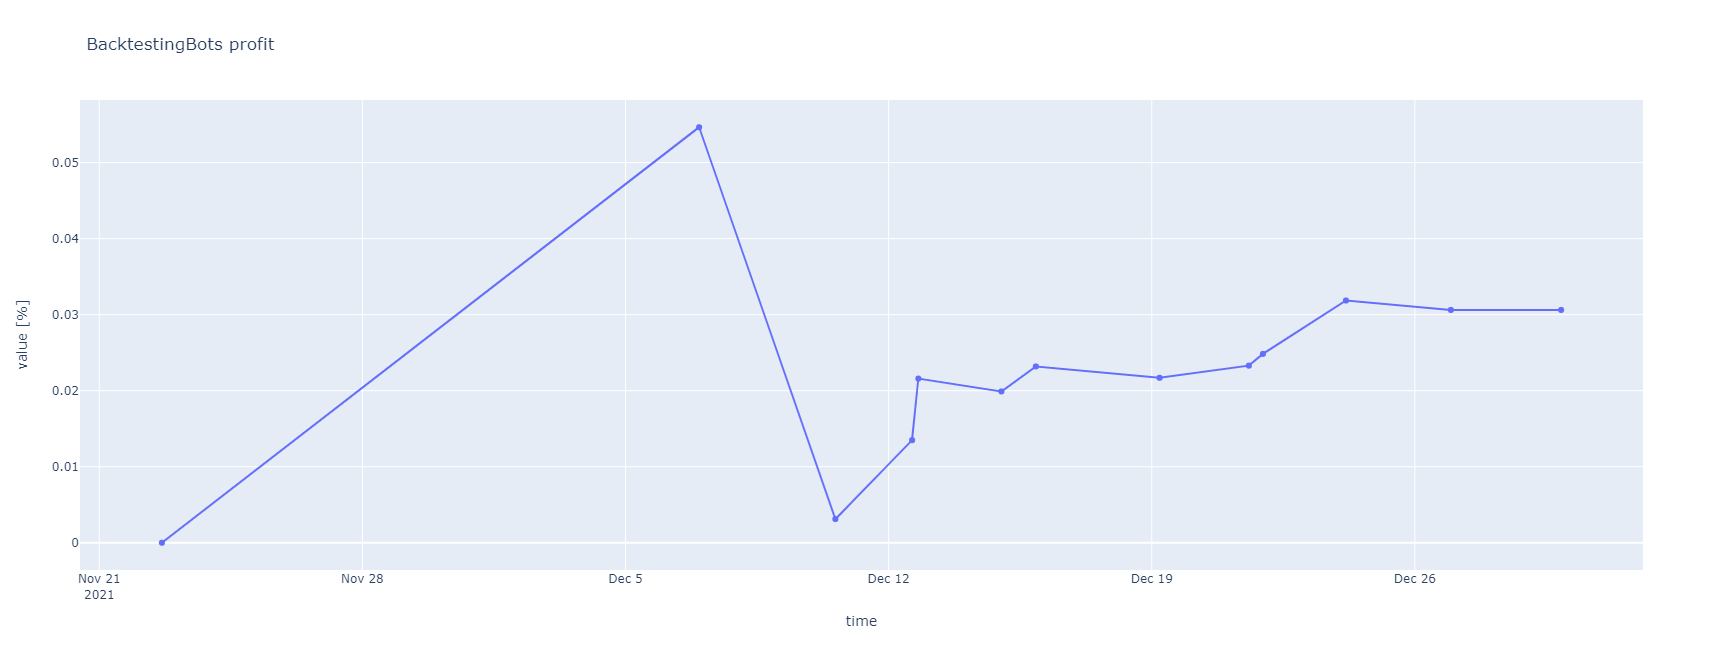

['candles + sma + ema', 'rsi']


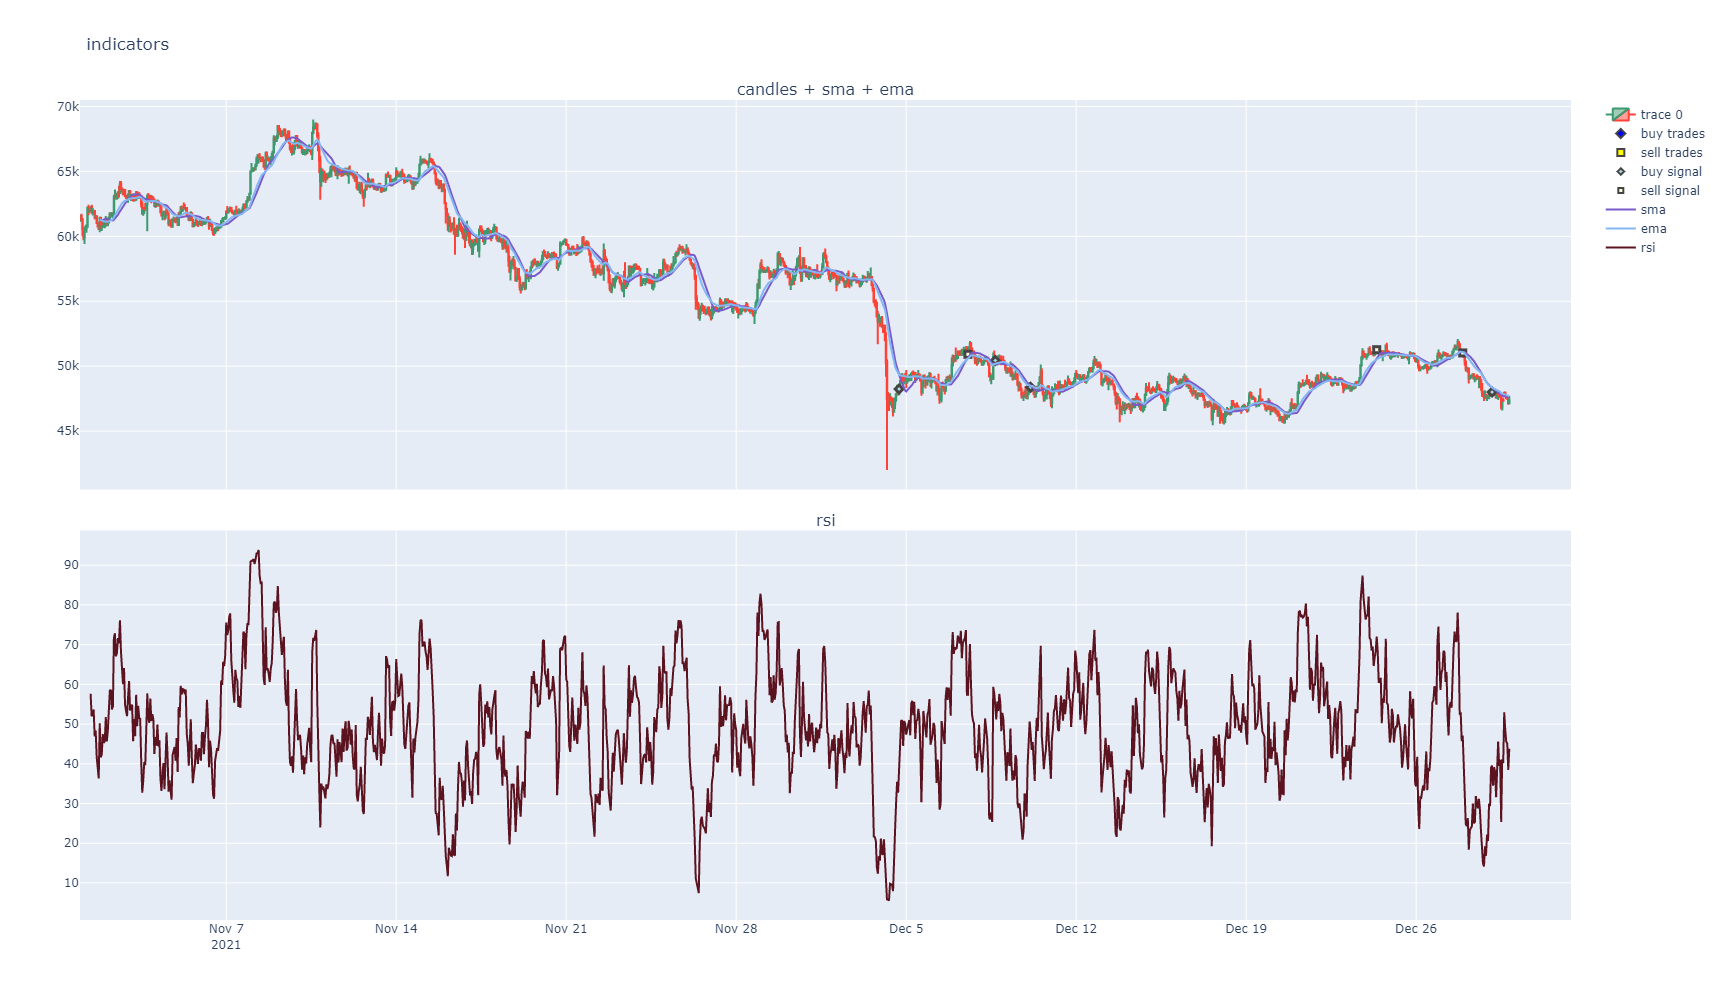

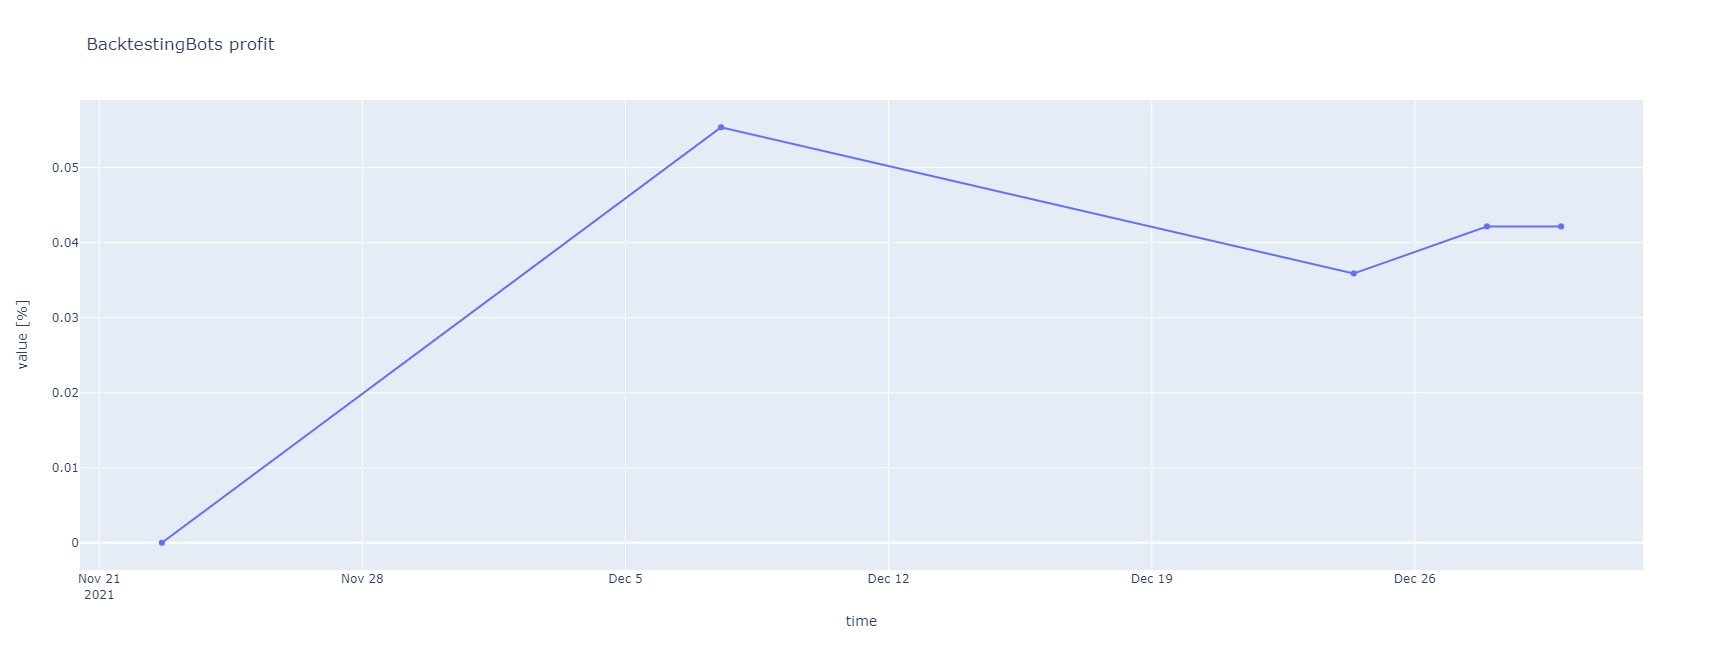

In [383]:
bot_ma = BacktestingBot('simple_strategy/config.yml')
results_ma = bot_ma.test_strategy(calc_indicators_simple_rsi_ma, check_buy_signals_simple_rsi_ma, check_sell_signals_simple_rsi_ma, time_start=datetime.datetime(2021,12,1))
# plot_candles(candles, results_rsi)
candles['sma'] = ta.SMA(candles, timeperiod=20)
candles['ema'] = ta.EMA(candles, timeperiod=20)
candles['rsi'] = ta.RSI(candles, timeperiod=10)

results_rsi = bot_ma.test_strategy(calc_indicators_simple_1, check_buy_signals_simple_1, check_sell_signals_simple_1, time_start=datetime.datetime(2021,12,1))
plot_indicators(candles, [],trades=results_rsi, show_signal=True, width=1800, height=1000)
plot_profit(results_rsi)
plot_indicators(candles, ['sma','ema','rsi'], one_plot=[True,True,False],trades=results_ma, show_signal=True, width=1800, height=1000)
plot_profit(results_ma)

/tmp/ipykernel_65/1360973860.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65/1360973860.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65/1360973860.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



['candles']


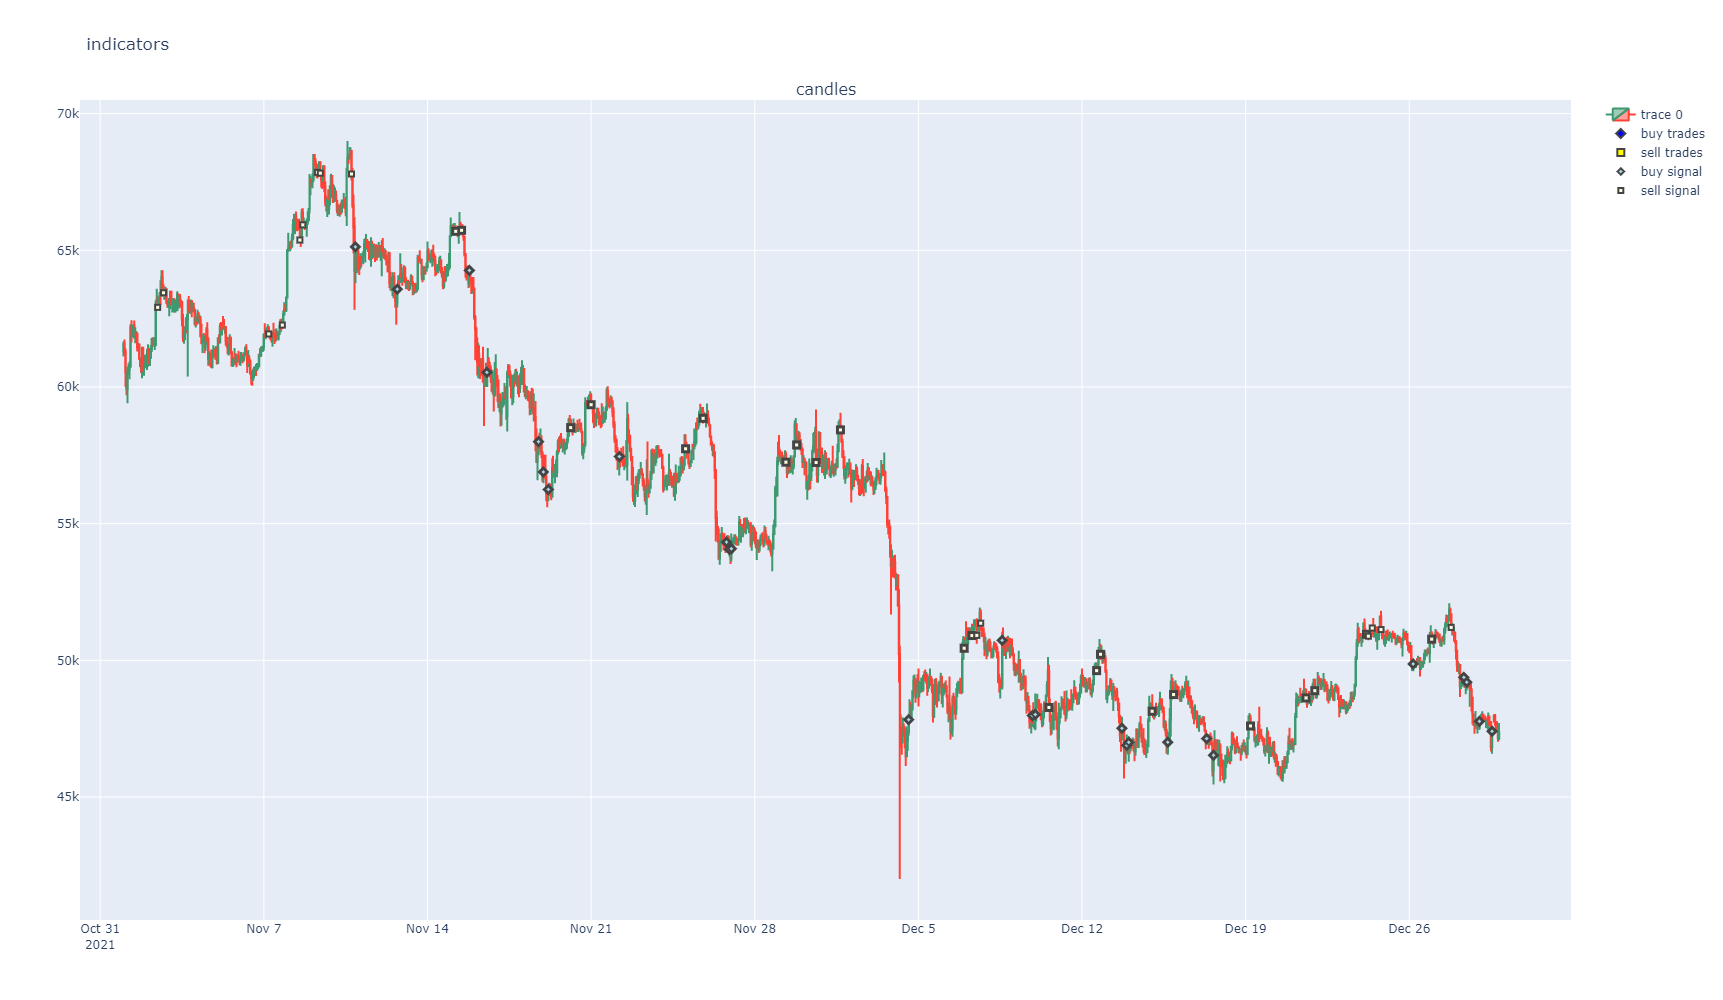

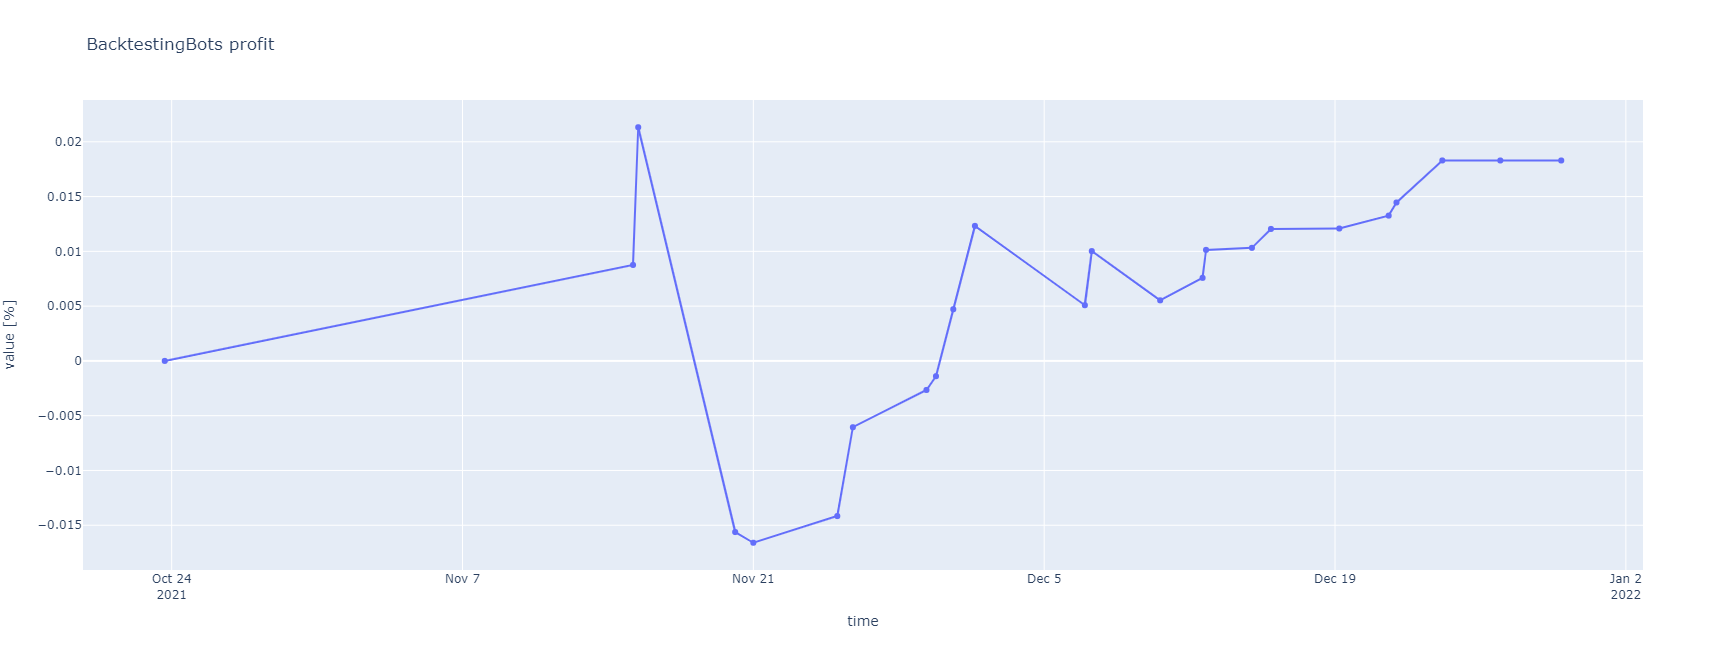

['candles + sma + ema', 'rsi']


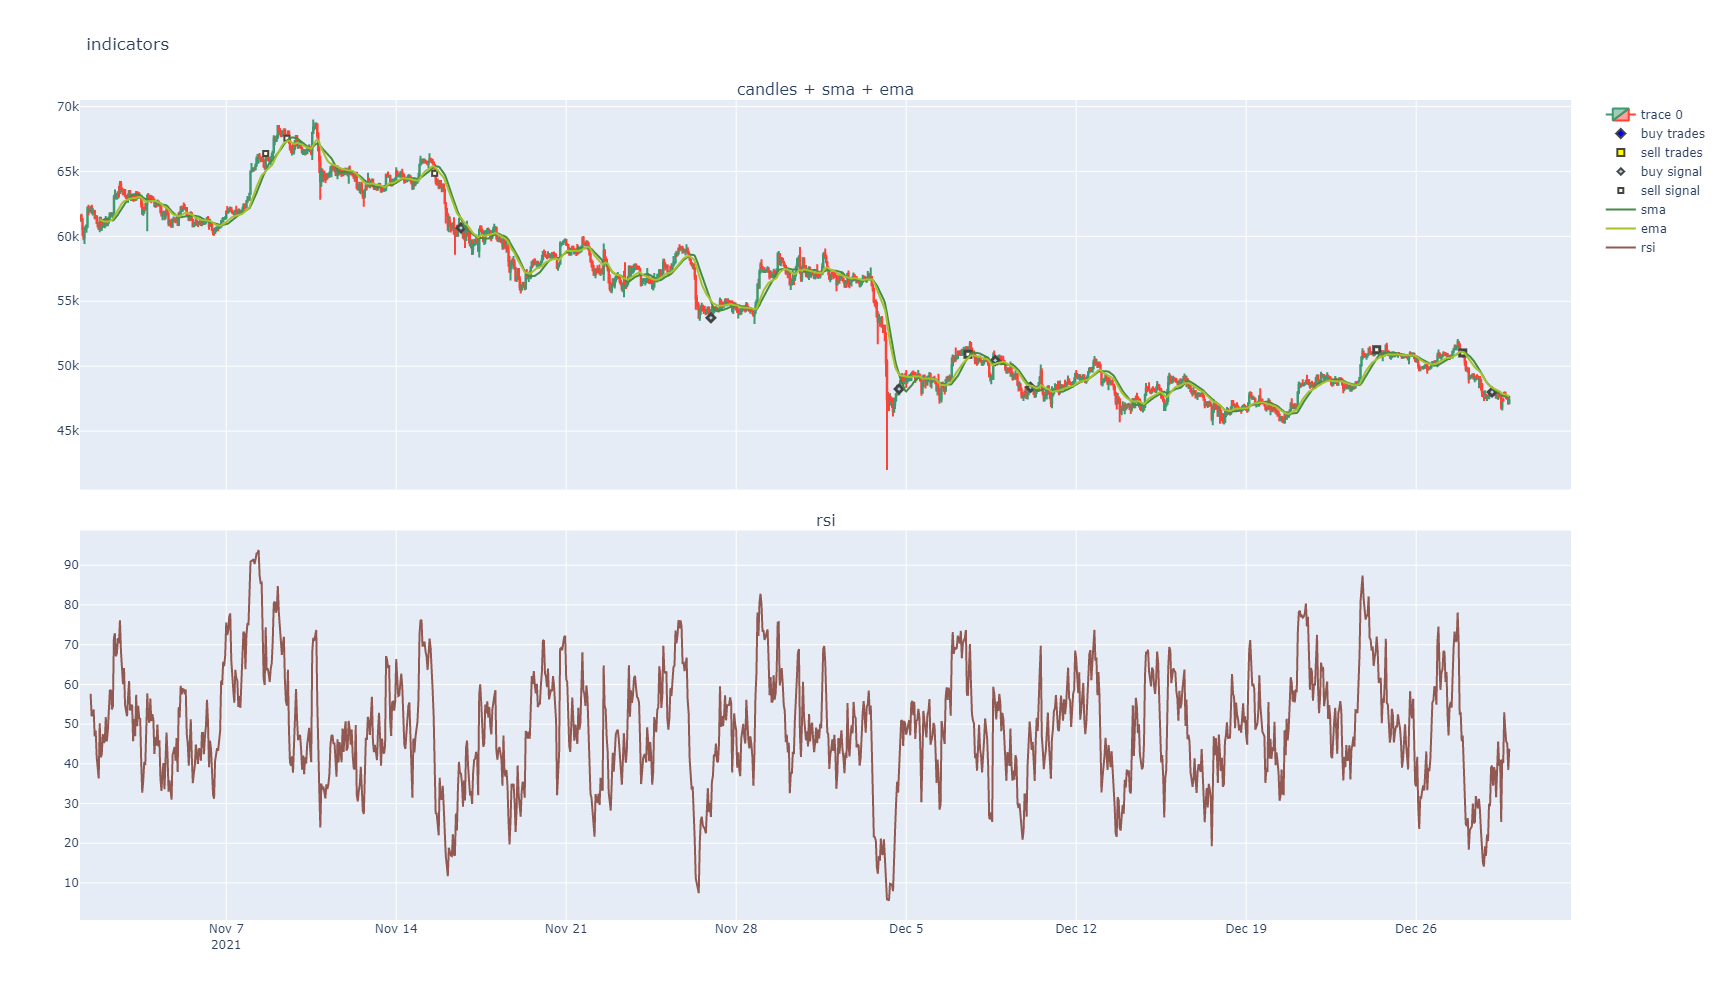

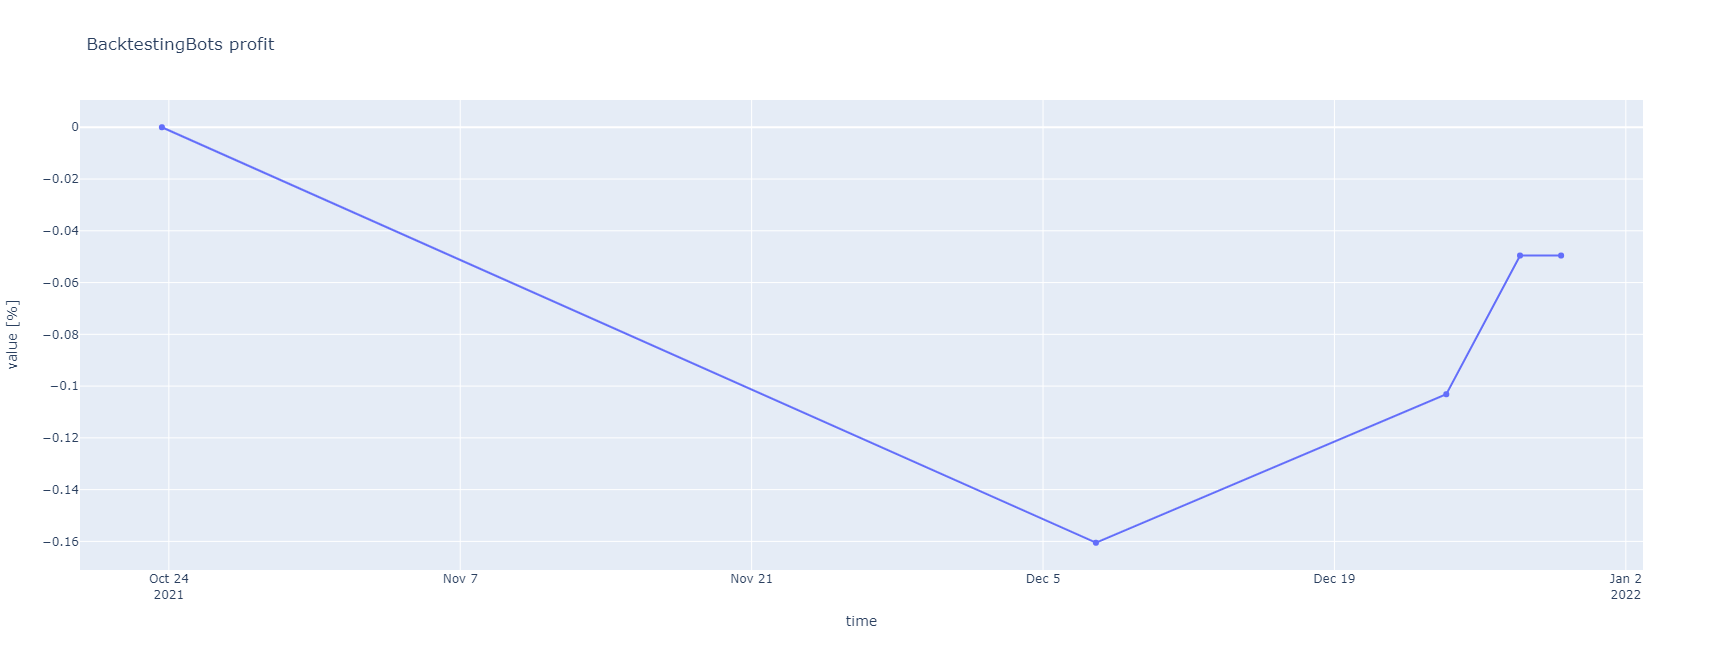

In [384]:
results_ma = bot_ma.test_strategy(calc_indicators_simple_rsi_ma, check_buy_signals_simple_rsi_ma, check_sell_signals_simple_rsi_ma, time_start=datetime.datetime(2021,11,1))
# plot_candles(candles, results_rsi)
candles, _ = get_candles('binance', 'BTC/USDT', '1h', time_start=datetime.datetime(2021,11,1))
candles['sma'] = ta.SMA(candles, timeperiod=20)
candles['ema'] = ta.EMA(candles, timeperiod=20)
candles['rsi'] = ta.RSI(candles, timeperiod=10)

results_rsi = bot_ma.test_strategy(calc_indicators_simple_1, check_buy_signals_simple_1, check_sell_signals_simple_1, time_start=datetime.datetime(2021,11,1))
plot_indicators(candles, [],trades=results_rsi, show_signal=True, width=1800, height=1000)
plot_profit(results_rsi)
plot_indicators(candles, ['sma','ema','rsi'], one_plot=[True,True,False],trades=results_ma, show_signal=True, width=1800, height=1000)
plot_profit(results_ma)

In [390]:
def check_buy_signals_simple_rsi_ma(indicators):
    buy = False
    threshold = 28
    if(indicators.iloc[-1]['sma'] < indicators.iloc[-1]['ema'] and 
      indicators.iloc[-2]['sma'] >= indicators.iloc[-2]['ema'] and (
          (indicators.iloc[-1]['rsi'] >= threshold and indicators.iloc[-2]['rsi'] < threshold) or
          (indicators.iloc[-2]['rsi'] >= threshold and indicators.iloc[-3]['rsi'] < threshold) or
          (indicators.iloc[-3]['rsi'] >= threshold and indicators.iloc[-4]['rsi'] < threshold) or
          (indicators.iloc[-4]['rsi'] >= threshold and indicators.iloc[-5]['rsi'] < threshold) or
          (indicators.iloc[-5]['rsi'] >= threshold and indicators.iloc[-6]['rsi'] < threshold) or
          (indicators.iloc[-6]['rsi'] >= threshold and indicators.iloc[-7]['rsi'] < threshold) or
          (indicators.iloc[-7]['rsi'] >= threshold and indicators.iloc[-8]['rsi'] < threshold)
      )):
        buy = True
    
#     if(indicators.iloc[-1]['rsi'] >= 28 and indicators.iloc[-2]['rsi'] < 28):
#         buy = True
    
    return buy
    

def check_sell_signals_simple_rsi_ma(indicators):
    sell = False
    threshold = 68.5
    if(indicators.iloc[-1]['sma'] > indicators.iloc[-1]['ema'] and 
      indicators.iloc[-2]['sma'] <= indicators.iloc[-2]['ema'] and (
          (indicators.iloc[-1]['rsi'] <= threshold and indicators.iloc[-2]['rsi'] > threshold) or
          (indicators.iloc[-2]['rsi'] <= threshold and indicators.iloc[-3]['rsi'] > threshold) or
          (indicators.iloc[-3]['rsi'] <= threshold and indicators.iloc[-4]['rsi'] > threshold) or
          (indicators.iloc[-4]['rsi'] <= threshold and indicators.iloc[-5]['rsi'] > threshold) or
          (indicators.iloc[-5]['rsi'] <= threshold and indicators.iloc[-6]['rsi'] > threshold) or
          (indicators.iloc[-6]['rsi'] <= threshold and indicators.iloc[-7]['rsi'] > threshold) or
          (indicators.iloc[-7]['rsi'] <= threshold and indicators.iloc[-8]['rsi'] > threshold)
      )):
    # if(indicators.iloc[-1]['rsi'] <= 68.5 and  indicators.iloc[-2]['rsi'] > 68.5):
        sell = True
    
    return sell

/tmp/ipykernel_65/1360973860.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65/1360973860.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65/1360973860.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



['candles']


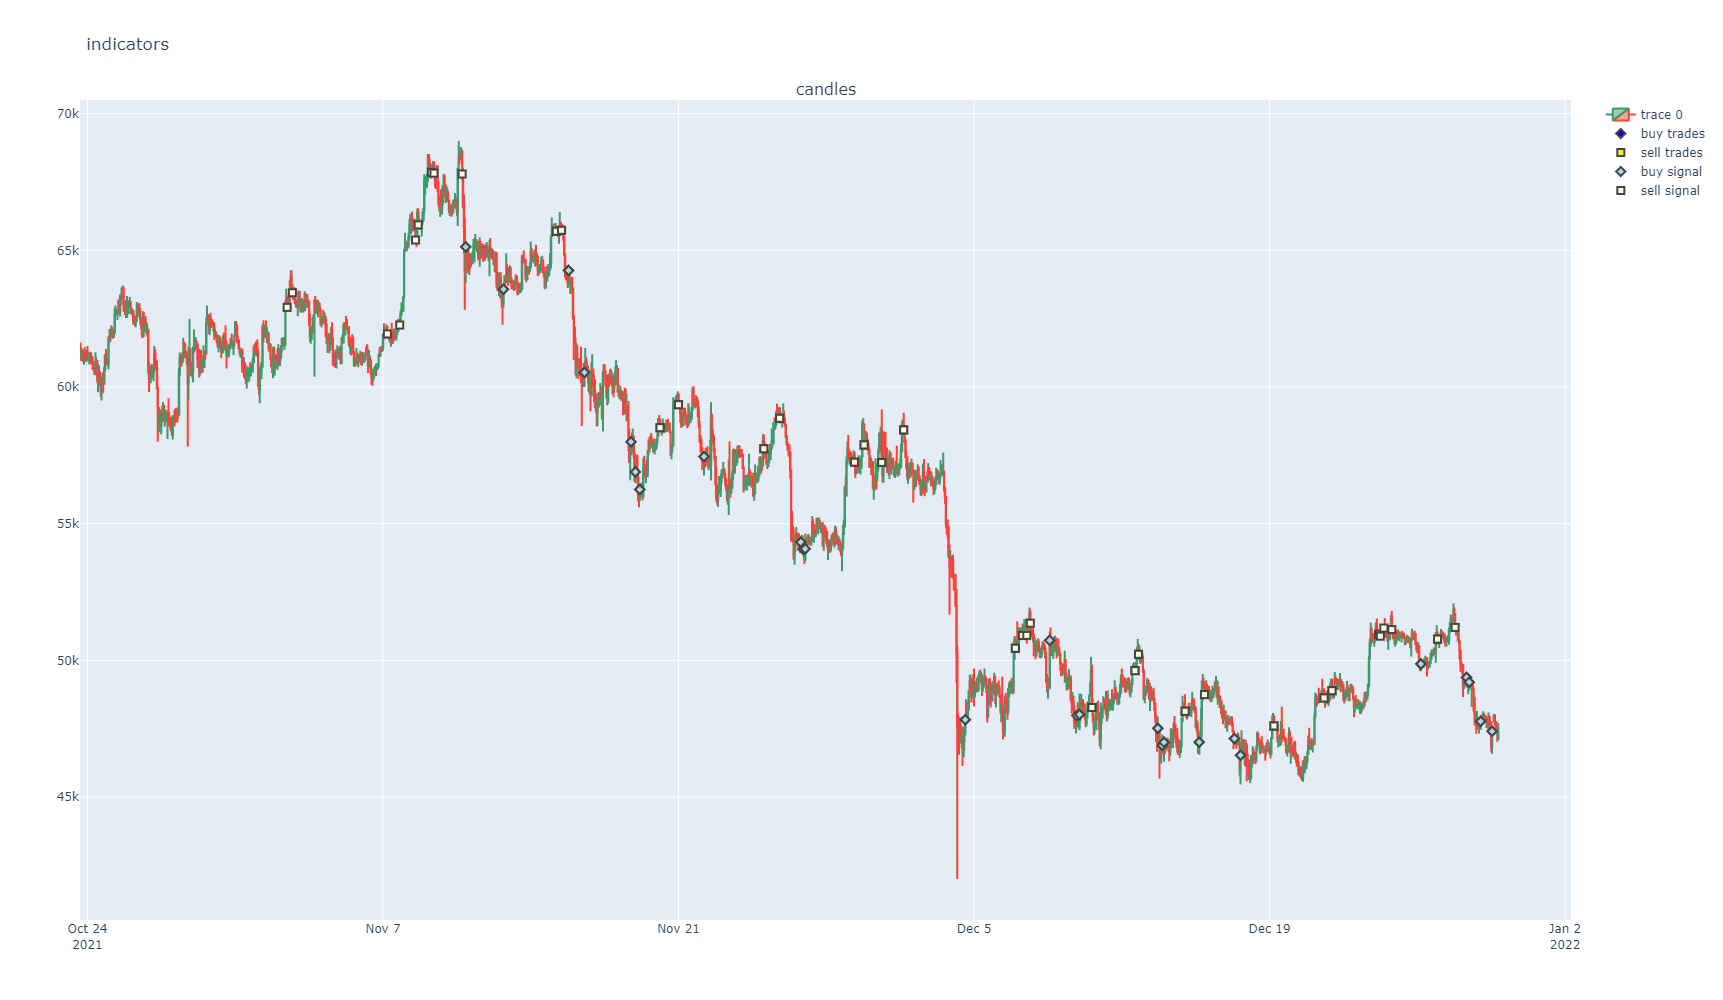

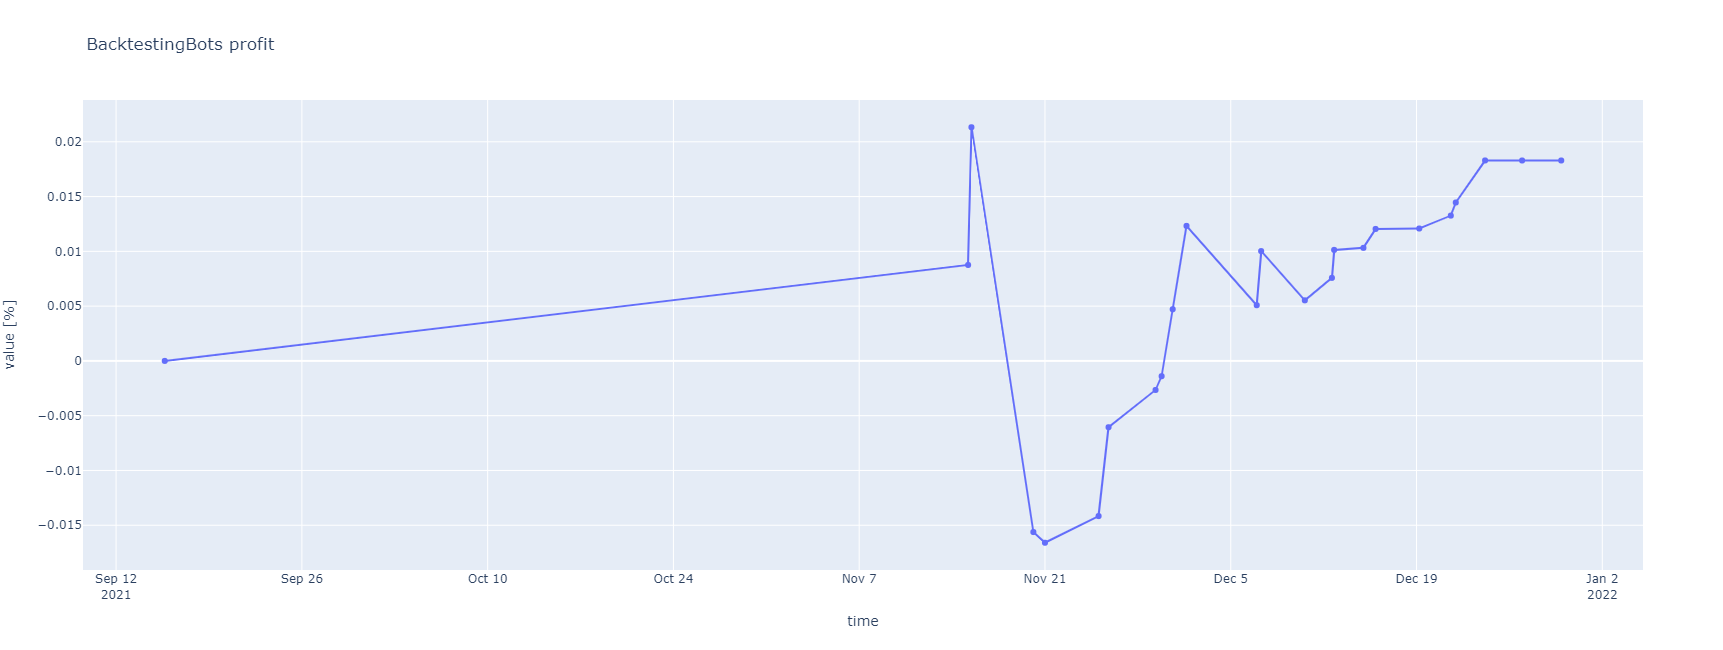

['candles + sma + ema', 'rsi']


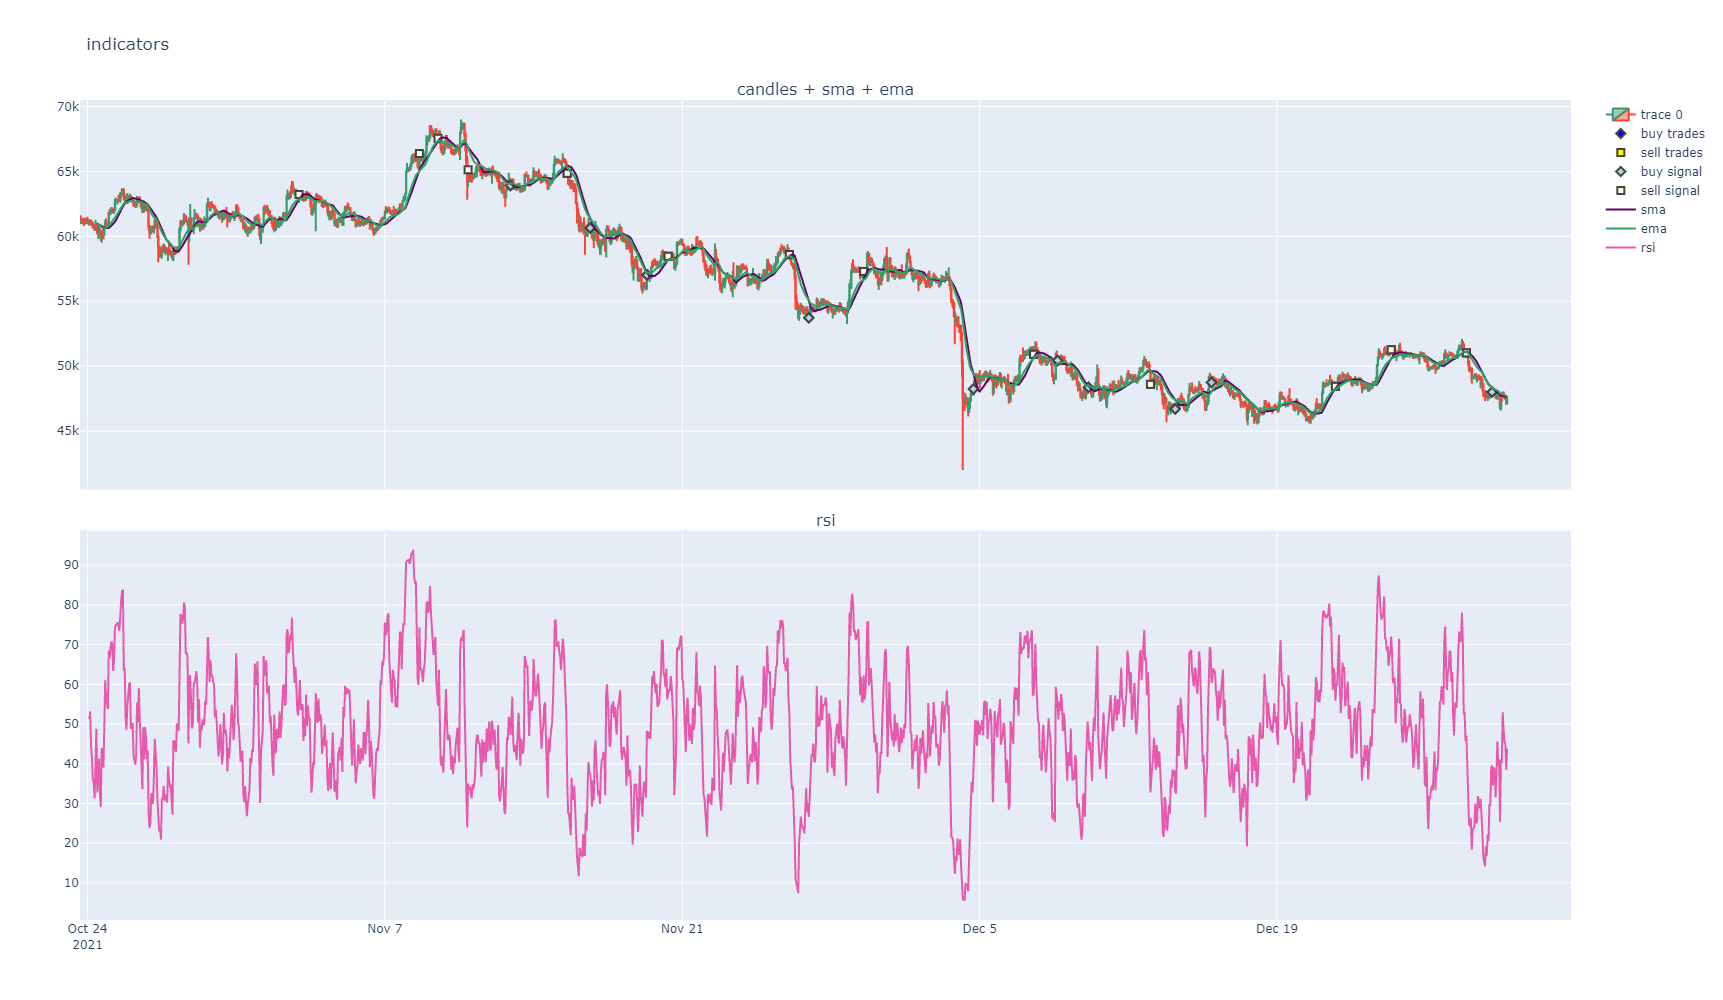

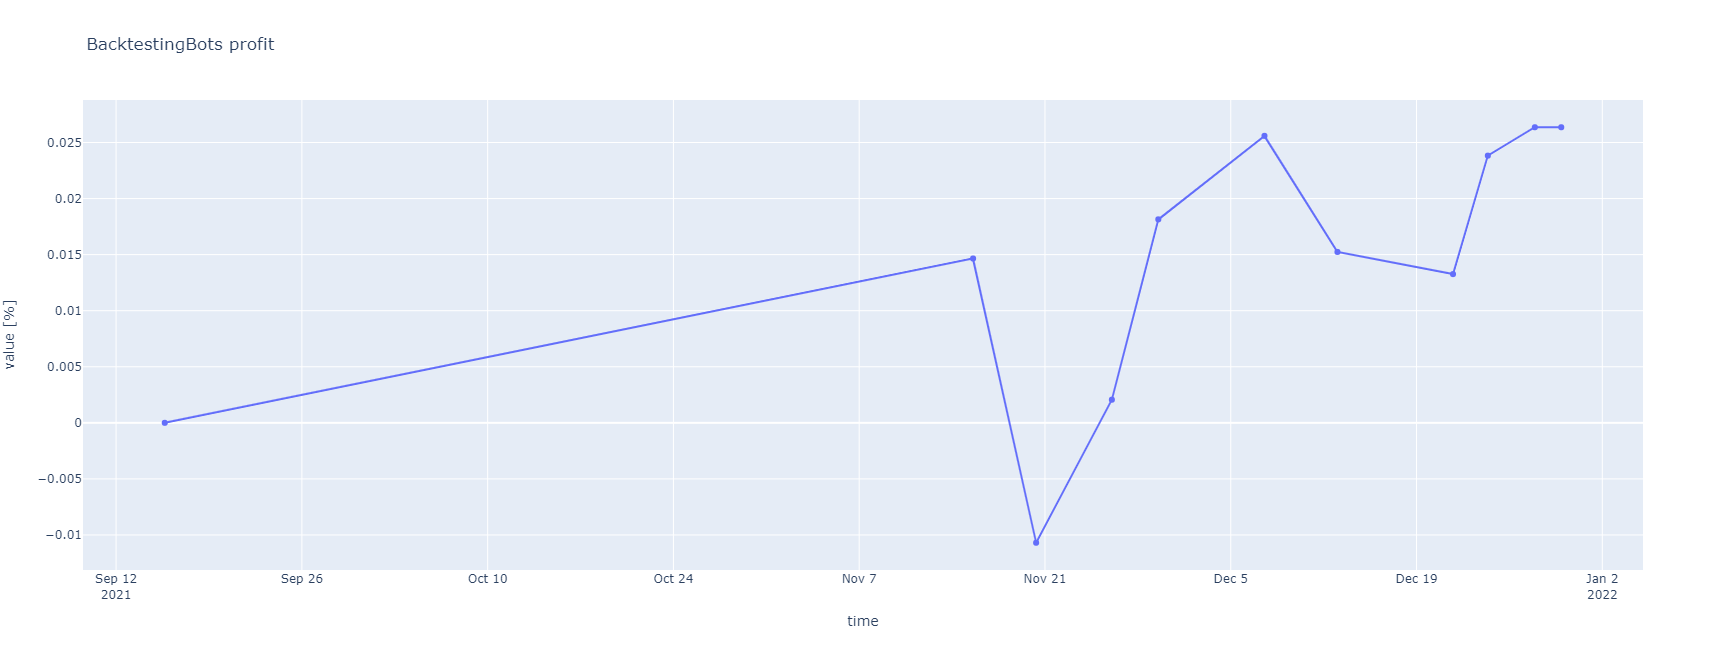

In [400]:
bot_ma = BacktestingBot('simple_strategy/config.yml')
results_ma = bot_ma.test_strategy(calc_indicators_simple_rsi_ma, check_buy_signals_simple_rsi_ma, check_sell_signals_simple_rsi_ma, time_start=datetime.datetime(2021,9,24))
# plot_candles(candles, results_rsi)
candles, _ = get_candles('binance', 'BTC/USDT', '1h', time_start=datetime.datetime(2021,9,24))
candles['sma'] = ta.SMA(candles, timeperiod=20)
candles['ema'] = ta.EMA(candles, timeperiod=20)
candles['rsi'] = ta.RSI(candles, timeperiod=10)

results_rsi = bot_ma.test_strategy(calc_indicators_simple_1, check_buy_signals_simple_1, check_sell_signals_simple_1, time_start=datetime.datetime(2021,9,24))
plot_indicators(candles, [],trades=results_rsi, show_signal=True, width=1800, height=1000)
plot_profit(results_rsi)
plot_indicators(candles, ['sma','ema', 'rsi'], one_plot=[True,True, False],trades=results_ma, show_signal=True, width=1800, height=1000)
plot_profit(results_ma)

no i jesteśmy na plusie w noej strategii, ale widać opóźnienia w reakcji, przez co nie przedaje idealnie w szczytach